# 熱帶波動判識與分析

## 熱帶波動理論簡介

熱帶波動是主導熱帶地區季內尺度變異的系統，它的理論最早在 Matsuno (1966) 文章中提出，這篇文章從熱帶 $\beta $ 面上的淺水方程 (shallow water equations) 出發，導出了熱帶波動頻散關係的理論解：
\begin{equation*}
    \omega ^{2} - k^2 - \dfrac{k}{\omega } = 2n+1, \qquad n = 1, 2, ...  
\end{equation*}

若將頻散關係方程式繪圖，可以得到如下圖的結果。

:::{figure-md}
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/15874aea-bc1f-4385-b84c-26698dd2748d/rog1687-fig-0002.png">

Dispersion curves for equatorial waves (up to $n = 4$) as a function of the nondimensional frequency, $\omega ^{*}$, and nondimensional zonal wave number, $k^{*}$, where $\omega ^{*} \equiv \left( \omega /\beta \sqrt{gh_e} \right) ^{1/2}$, and $k^{*} \equiv k\left( \sqrt{gh_e} / \beta  \right) ^{1/2}$. For all but the Kelvin wave, these dispersion curves are solutions of equation (1). Westward propagating waves (relative to the zero basic state) appear on the left, and eastward propagating waves appear on the right. For consistency with equation (1), the Kelvin wave solution is labeled as $n = −1$. (Source: Kiladis et al. (2009))
:::

在這張圖中，$k^{*} > 0$ 的部分代表往東傳遞的波動，$k^{*} < 0$ 則代表往西傳遞的波動。

隨後，許多觀測實驗證實了熱帶確實有這些往東和往西的波動存在，以及當衛星觀測和再分析資料越來越盛行後，從波譜分析的結果也可以發現波譜的峰值區域和理論解非常吻合，甚至可以根據波譜分析的結果進行適當的濾波來得到熱帶波動的資料。以下會介紹兩種常用的分析方法，其一是 Wheeler and Kiladis (1999) 提出的時空濾波法 (space-time filtering technique)，其二是 Yang et al. (2003) 提出的雙曲柱狀函數 (PCF) 投影法 (2D spatial projection on the parabolic cylinder functions, 2DS-PCF) 方法。其他還有許多熱帶波動辨識的方法，詳細的介紹與回顧請見 Knippertz et al. (2022)。 

## 時空濾波 (Space-time filtering)

時空濾波即在資料的經度和時間兩個維度軸上進行快速傅立葉變換 (fast Fourier transform, FFT)，然後將對應要保留的波段留下來，其他設為0，再進行反變換 (reversed FFT)，就可以得到濾波的資料。這個方法可以用在任何變數上，非常彈性。圖2為外逸長波輻射 (OLR) 時空頻譜的範例，可以看到幾個訊號特別強的地方，就是理論上熱帶波動的頻譜範圍。

:::{figure-md}
<img src="./images/fig.A6-1_tw_ps.png">

The wavenumber ($k$)-frequency ($\omega $) spectra of OLR data from 1981 to 2018 between 15°S and 15°N, without symmetric partition. The thick polygons indicate domains for the filtered MJO, Kelvin waves, ER waves, and MRG waves/TD-type disturbances. Source: Tsai et al. (2020).
:::

時空濾波的程式由 Carl Schreck III 團隊提供 (https://ncics.org/portfolio/monitor/mjo/)。程序簡單介紹如下：
1. 計算資料的距平，其中氣候場只保留日氣候平均的前三個球諧函數 (請見第六單元)。
2. 將資料的距平帶入時空濾波函數。

```{note}
輸入時空濾波的資料，經度範圍必須包含全球的範圍！
```

In [1]:
#################################################
# MODULE: kf_filter
#################################################
def kf_filter(inData,obsPerDay,tMin,tMax,kMin,kMax,hMin,hMax,waveName):
    
    import numpy as np
    from scipy import signal
    import math
    
    mis = -999.
    
    timeDim = inData.shape[0]
    lonDim = inData.shape[1]
	
    # Reshape data from [time,lon] to [lon,time]
    originalData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(timeDim):
        test=0
        for counterY in range(lonDim-1,-1,-1):
            originalData[test,counterX]=inData[counterX,counterY]
            test+=1
	
    # Detrend the Data
    detrendData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(lonDim):
        detrendData[counterX,:]=signal.detrend(originalData[counterX,:])
	
    # Taper 
    taper=signal.tukey(timeDim,0.05,True)
    taperData=np.zeros([lonDim,timeDim],dtype='f')
    for counterX in range(lonDim):
        taperData[counterX,:]=detrendData[counterX,:]*taper
	
    # Perform 2-D Fourier Transform
    fftData=np.fft.rfft2(taperData)
    kDim=lonDim 
    freqDim=round(fftData.shape[1])
	
    # Find the indeces for the period cut-offs
    jMin = int(round( ( timeDim * 1. / ( tMax * obsPerDay ) ), 0 ))
    jMax = int(round( ( timeDim * 1. / ( tMin * obsPerDay ) ), 0 ))
    jMax = min( ( jMax, freqDim ) )

    # Find the indices for the wavenumber cut-offs
    # This is more complicated because east and west are separate
    if( kMin < 0 ):
        iMin = round( ( kDim + kMin ), 3 )
        iMin = max( ( iMin, ( kDim / 2 ) ) )
    else:
        iMin = round( kMin, 3 )
        iMin = min( ( iMin, ( kDim / 2 ) ) )

    if( kMax < 0 ):
        iMax = round( ( kDim + kMax ), 3 )
        iMax = max( ( iMax, ( kDim / 2 ) ) )
    else:
        iMax = round( kMax, 3 )
        iMax = min( ( iMax, ( kDim / 2 ) ) )
	  
    # set the appropriate coefficients to zero
    iMin=int(iMin)
    iMax=int(iMax)
    jMin=int(jMin)
    jMax=int(jMax)
    if( jMin > 0 ):
        fftData[:, :jMin-1 ] = 0
    if( jMax < ( freqDim - 1 ) ):
        fftData[:, jMax+1: ] = 0

    if( iMin < iMax ):
        # Set things outside the range to zero, this is more normal
        if( iMin > 0 ):
            fftData[:iMin-1, : ] = 0
        if( iMax < ( kDim - 1 ) ):
            fftData[iMax+1:, : ] = 0
    else:
        # Set things inside the range to zero, this should be somewhat unusual
        fftData[iMax+1:iMin-1, : ] = 0
	
    # Find constants
    PI = math.pi
    beta = 2.28e-11
    if hMin != -999:
        cMin = float( 9.8 * float(hMin) )**0.5
    else:
        cMin=hMin
    if hMax != -999:
        cMax = float( 9.8 * float(hMax) )**0.5
    else:
        cMax=hMax
    c = np.array([cMin,cMax])
    spc = 24 * 3600. / ( 2 * PI * obsPerDay ) # seconds per cycle
	
    # Now set things to zero that are outside the Kelvin dispersion
    for i in range(0,kDim):
        # Find Non-Dimensional WaveNumber (k)
        if( i > ( kDim / 2 ) ):
            # k is negative
            k = ( i - kDim  ) * 1. / (6.37e6) # adjusting for circumfrence of earth
        else:
            # k is positive
            k = i * 1. / (6.37e6) # adjusting for circumfrence of earth

        # Find Frequency
        freq = np.array([ 0, freqDim * (1. / spc) ]) #waveName='None'
        jMinWave = 0
        jMaxWave = freqDim	
        if waveName.lower() == "kelvin":
            freq = k * c
        if waveName.lower() == "er":
            freq = -beta * k / ( k**2 + 3. * beta / c )
        if waveName.lower() == "ig1":
            freq = ( 3 * beta * c + k**2 * c**2 )**0.5
        if waveName.lower() == "ig2":
            freq = ( 5 * beta * c + k**2 * c**2 )**0.5
        if waveName.lower() == "mrg" or waveName.lower()=="ig0":   	
           if( k == 0 ):
               freq = ( beta * c )**0.5
           else:
               if( k > 0):
                   freq = k * c * ( 0.5 + 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )
               else:
                freq = k * c * ( 0.5 - 0.5 * ( 1 + 4 * beta / ( k**2 * c ) )**0.5 )	
		
        # Get Min/Max Wave 
        if(hMin==mis):
            jMinWave = 0
        else:
            jMinWave = int( math.floor( freq[0] * spc * timeDim ) )

        if(hMax==mis):
            jMaxWave = freqDim
        else:
            jMaxWave = int( math.ceil( freq[1] * spc * timeDim ) )

        jMaxWave = max(jMaxWave, 0)
        jMinWave = min(jMinWave, freqDim)
		
        # set the appropriate coefficients to zero
        i=int(i)
        jMinWave=int(jMinWave)
        jMaxWave=int(jMaxWave)
        if( jMinWave > 0 ):
            fftData[i, :jMinWave-1] = 0
        if( jMaxWave < ( freqDim - 1 ) ):
            fftData[i, jMaxWave+1:] = 0
	
    # perform the inverse transform to reconstruct the data
    returnedData=np.fft.irfft2(fftData) 
	
    # Reshape data from [lon,time] to [time,lon]
    outData=np.zeros([timeDim,lonDim],dtype='f')
    for counterX in range(returnedData.shape[1]):
        test=0
        for counterY in range(lonDim-1,-1,-1):
            outData[counterX,counterY]=returnedData[test,counterX] 
            test+=1
    
    # Return Result
    return (outData)


In [2]:
def smthClmDay(clmDay, nHarm):
    
    from scipy.fft import rfft, irfft
    
    nt, ny, nx = clmDay.shape
    cf = rfft(clmDay.values, axis=0)     # xarray.DataArray.values 可將DataArray 轉換成numpy.ndarray。
    cf[nHarm,:,:] = 0.5*cf[nHarm,:,:]    # mini-taper.
    cf[nHarm+1:,:,:] = 0.0               # set all higher coef to 0.0
    icf = irfft(cf, n=nt, axis=0)       # reconstructed series
    clmDaySmth = clmDay.copy(data=icf, deep=False)
    return(clmDaySmth)

In [3]:
# Import modules
import numpy as np
import xarray as xr

lats, latn = -20, 20 # 只選擇熱帶範圍
name = 'olra'

olr = xr.open_dataset('./data/olr.nc').sel(lat=slice(lats,latn)).olr
olrDayClm = olr.groupby('time.dayofyear').mean('time')
olrDayClm_sm = smthClmDay(olrDayClm, 3)
# 只選2017, 2018年做範例，可以選任意時間長度 (建議至少1年)
olra = olr.sel(time=slice('2017-01-01','2018-12-31')).groupby('time.dayofyear') - olrDayClm_sm 

olra

<xarray.DataArray 'olr' (time: 730, lat: 40, lon: 360)>
array([[[ 16.380768  ,  17.168976  ,  17.851715  , ...,  17.053589  ,
          16.067657  ,  15.664886  ],
        [ 16.75711   ,  17.412537  ,  17.013672  , ...,  12.450287  ,
          13.341797  ,  15.062683  ],
        [ 14.054718  ,  14.679474  ,  14.075806  , ...,   9.722412  ,
          11.569977  ,  12.888275  ],
        ...,
        [ 11.100403  ,  10.695831  ,  10.361023  , ...,  11.2274475 ,
          12.5383    ,  10.187225  ],
        [  8.687775  ,   9.050079  ,   7.7844543 , ...,  11.915253  ,
          11.584686  ,  10.397156  ],
        [ 11.788055  ,   8.504059  ,   6.5397644 , ...,  16.114655  ,
          14.831329  ,  11.902344  ]],

       [[ 16.882385  ,  16.851288  ,  17.246857  , ...,  18.198914  ,
          16.867859  ,  16.242828  ],
        [ 15.078766  ,  13.773102  ,  13.533112  , ...,  20.839447  ,
          17.823395  ,  15.5312195 ],
        [ 11.530273  ,  12.067474  ,  15.291016  , ...,  14.027985  ,
          11.882874  ,  10.712891  ],
...
        [-34.450195  , -43.519882  , -34.36879   , ..., -13.5963745 ,
         -18.14357   , -31.10965   ],
        [-18.831131  , -26.859772  , -31.448883  , ...,  10.565292  ,
          -2.8655853 , -10.68837   ],
        [  6.074768  ,  -3.823471  , -15.938919  , ...,  18.61168   ,
          17.26979   ,  11.514587  ]],

       [[ -9.893219  ,  -7.201172  ,  -0.78359985, ...,  -1.2973022 ,
          -3.3666992 ,  -6.4829407 ],
        [-19.12323   , -15.406616  ,  -9.28949   , ...,  -7.4835205 ,
          -9.953217  , -10.572876  ],
        [-23.6315    , -27.043655  , -16.556519  , ..., -11.582275  ,
         -13.263733  , -13.371033  ],
        ...,
        [ -7.89328   ,  -5.9326477 ,  -5.8309326 , ..., -25.945755  ,
         -13.093338  , -12.713745  ],
        [-10.086914  ,  -4.398468  ,  -7.0507355 , ..., -11.004013  ,
         -10.912903  ,  -6.5914    ],
        [ -3.9572144 ,  -2.9132996 ,   3.1249695 , ..., -12.474991  ,
          -5.3866425 ,  -1.2779541 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float32 -19.5 -18.5 -17.5 -16.5 ... 16.5 17.5 18.5 19.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

In [4]:
# wave filter
mis = -999.
obsPerDay = 1.
lat = olra.lat.values

lf     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mjo    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
er     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
kelvin = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mt     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mrg    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))

# lf parameters 
lf_filter="above 120 days"
lf_wavenumber=np.array([mis,mis],dtype='f')
lf_period=np.array([120,mis],dtype='f')
lf_depth=np.array([mis*-1.,mis],dtype='f')

# mjo parameters 
mjo_filter="Kiladis et al. (2005 JAS) for 20-100"
mjo_wavenumber=np.array([1,5],dtype='f')
mjo_period=np.array([30,96],dtype='f')
mjo_depth=np.array([mis,mis],dtype='f')
#mjo = olra.copy(deep=False)
    
# er parameters 
er_filter="Kiladis et al. (2009 Rev. Geophys.)"
er_wavenumber=np.array([-10,-1],dtype='f')
er_period=np.array([9.7,48],dtype='f')
er_depth=np.array([8,90],dtype='f')
#er = olra.copy(deep=False)

# kw parameters
kelvin_filter="Straub & Kiladis (2002) to 20 days"
kelvin_wavenumber=np.array([1,14],dtype='f')
kelvin_period=np.array([2.5,30],dtype='f')
kelvin_depth=np.array([8,90],dtype='f')
#kelvin = olra.copy(deep=False)

# mt parameters
mt_filter="MRG-TD type wave filter (Frank & Roundy 2006)"
mt_wavenumber=np.array([-14,0],dtype='f')
mt_period=np.array([2.5,10],dtype='f')
mt_depth=np.array([mis,mis],dtype='f')
#mt = olra.copy(deep=False)

# mrg parameters
mrg_filter="MRG-TD type wave filter"
mrg_wavenumber=np.array([-10,-1],dtype='f')
mrg_period=np.array([3,9.6],dtype='f')
mrg_depth=np.array([8,90],dtype='f')
#mrg = olra.copy(deep=False)

for y in lat: 
    #print('latitude: ' + str(y))
    #################################################
    # Filter
    #################################################
    #lf
    lf.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        lf_period[0],lf_period[1],
                        lf_wavenumber[0],lf_wavenumber[1],
                        lf_depth[0],lf_depth[1],"none")
    
    #mjo
    mjo.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        mjo_period[0],mjo_period[1],
                        mjo_wavenumber[0],mjo_wavenumber[1],
                        mjo_depth[0],mjo_depth[1],"none")
    
    #er 
    er.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                       obsPerDay,
                       er_period[0],er_period[1],
                       er_wavenumber[0],er_wavenumber[1],
                       er_depth[0],er_depth[1],"er")
    
    ## kw
    kelvin.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                           obsPerDay,
                           kelvin_period[0],kelvin_period[1],
                           kelvin_wavenumber[0],kelvin_wavenumber[1],
                           kelvin_depth[0],kelvin_depth[1],"kelvin")
    
    # mt 
    mt.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                       obsPerDay,
                       mt_period[0],mt_period[1],
                       mt_wavenumber[0],mt_wavenumber[1],
                       mt_depth[0],mt_depth[1],"none")
        
    # mrg 
    mrg.loc[:,y,:] = kf_filter(olra.loc[:,y,:].values,
                        obsPerDay,
                        mrg_period[0],mrg_period[1],
                        mrg_wavenumber[0],mrg_wavenumber[1],
                        mrg_depth[0],mrg_depth[1],"mrg")
    
er

<xarray.DataArray (time: 730, lat: 40, lon: 360)>
array([[[ 0.41869953,  0.74632704,  1.07617247, ..., -0.48732913,
         -0.20450903,  0.09961336],
        [ 0.16254583,  0.38559777,  0.6125918 , ..., -0.44736761,
         -0.25748172, -0.05300589],
        [ 0.1102673 ,  0.26533216,  0.4232206 , ..., -0.31864047,
         -0.18367998, -0.0400544 ],
        ...,
        [-5.61130285, -5.43971968, -5.16630745, ..., -5.5121479 ,
         -5.64538622, -5.67955065],
        [-6.04585648, -5.95039845, -5.75541639, ..., -5.74995708,
         -5.9418354 , -6.04211521],
        [-6.54671526, -6.63207436, -6.63014841, ..., -5.81441212,
         -6.13140631, -6.37794161]],

       [[ 0.76235485,  1.1360811 ,  1.49986124, ..., -0.35526246,
          0.00991862,  0.38476983],
        [ 0.05015931,  0.32514107,  0.60003805, ..., -0.73913151,
         -0.48576149, -0.22138192],
        [-0.28530368, -0.08856484,  0.11314388, ..., -0.82769424,
         -0.6566962 , -0.47528636],
...
        [-4.84334517, -5.02544785, -5.14676905, ..., -4.01491976,
         -4.32888174, -4.60822058],
        [-5.2019372 , -5.39951229, -5.54685974, ..., -4.38925982,
         -4.68813229, -4.96198225],
        [-5.03971434, -5.30969191, -5.55134392, ..., -4.13197279,
         -4.44375563, -4.74866533]],

       [[ 0.36513716,  0.63959444,  0.92730278, ..., -0.32453212,
         -0.12197281,  0.10952018],
        [ 0.52740246,  0.72218305,  0.9244988 , ...,  0.02059937,
          0.17357652,  0.34348166],
        [ 0.65549105,  0.81336552,  0.97305393, ...,  0.21653658,
          0.35472208,  0.50181794],
        ...,
        [-5.3761735 , -5.42974091, -5.39585304, ..., -4.74491978,
         -5.02649164, -5.23962402],
        [-5.70784616, -5.81145811, -5.83556461, ..., -4.9854064 ,
         -5.28673029, -5.53047705],
        [-5.8078804 , -6.04300451, -6.21886206, ..., -4.82505178,
         -5.19027758, -5.52087641]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 ... 16.5 17.5 18.5 19.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [5]:
# Output files

outdir = './data/olr_ccew_sample/'

#print(lf) 
lf.to_netcdf(outdir+'olr_2017-2018_MJO.nc')

#print(mjo)
mjo.to_netcdf(outdir+'olr_2017-2018_MJO.nc')

#print(er)
er.to_netcdf(outdir+'olr_2017-2018_ER.nc')

#print(kelvin)
kelvin.to_netcdf(outdir+'olr_2017-2018_KW.nc')

#print(mt)
mt.to_netcdf(outdir+'olr_2017-2018_MT.nc')

#print(mrg)
mrg.to_netcdf(outdir+'olr_2017-2018_MRG.nc')

我們選定2017/12-2018/02期間，繪製5˚-15˚N平均的 OLR、濾波的MJO、ER波、MRG/TD波哈莫圖。

In [6]:
import cmaps
cmap=cmaps.sunshine_diff_12lev

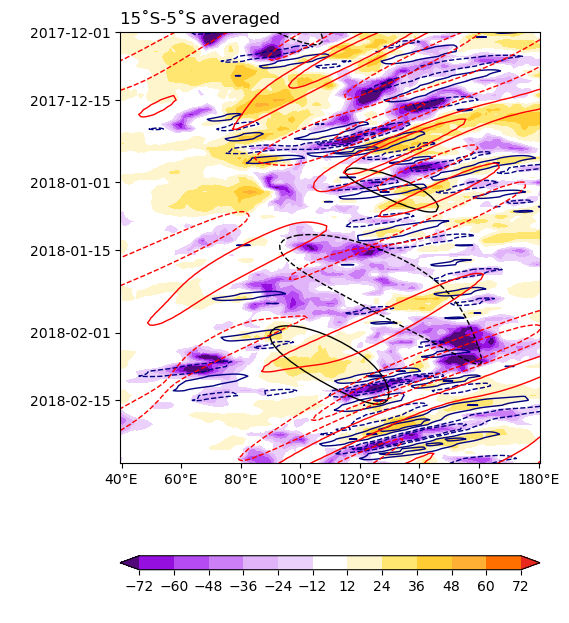

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmaps

time1 = '2017-12-01'
time2 = '2018-02-28'
lon1 = 39 
lon2 = 181
lats = 5
latn = 15

olrh     =   olra.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
er_hovm  =     er.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mjo_hovm =    mjo.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mt_hovm  =     mt.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
kw_hovm  = kelvin.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)

# Plot settings
plt.figure(figsize=(6, 8))     
ax = plt.axes() 
ax.set_xticks(np.arange(40,200,20))
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)

clevs = [-72,-60,-48,-36,-24,-12,12,24,36,48,60,72]
plt.title("OLR anomaly", loc='left')
hovm_plot = olrh.plot.contourf(x="lon", y="time",
                               ax=ax, 
                               levels=clevs,                    
                               cmap=cmap,  
                               yincrease=False,                 # y axis be increasing from top to bottom
                               add_colorbar=True, 
                               extend='both',                   # color bar 兩端向外延伸
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' ', 'ticks':clevs})
#kw_plot = kw_hovm.plot.contour(x='lon',y='time', ax=ax,
#                               levels=[-30,-15,15,30], 
#                               colors='blue',linewidths=1,
#                               yincrease=False) 
mt_plot = mt_hovm.plot.contour(x='lon',y='time', ax=ax,
                               levels=[-30,-15,15,30], 
                               colors='navy',linewidths=1,
                               yincrease=False) 
mjo_plot = mjo_hovm.plot.contour(x='lon',y='time', ax=ax,
                                 levels=[-30,-20,-10,10,20,30], 
                                 colors='black',linewidths=1,
                                 yincrease=False)
er_plot  = er_hovm.plot.contour(x='lon',y='time', ax=ax,
                                levels=[-30,-20,-10,10,20,30], 
                                colors='red',linewidths=1,
                                yincrease=False)

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title(' ')
ax.set_title('15˚S-5˚S averaged', loc='left')

plt.subplots_adjust(left=0.2)

plt.show()

上圖中，底色是濾波前OLR距平，黑色往東的等值線代表MJO，紅色往西的等值線代表赤道羅士比波 (ER waves)，深藍色往西的等值線是混合羅士比－重力波和熱帶擾動 (MRG/TD wave)，且實線 (正值) 代表對流抑制相位，虛線 (負值) 代表對流活躍相位。